# Customer df Prediction using XGBoost

Mobile phone services provides have historically had problems with high customer turnover.  Leaving a mobile phone operator is easy for an end customer, but as a mobile provider offering incentives to retain customers is often more cost effective/ more profitable than the cost of losing and reacquiring a customer later.  

This analysis demonstrates how to predict which customers may leave so that provider could offer timely incentives to retain their business.

In [82]:
# download data
from hyperopt import fmin, hp, STATUS_OK, tpe, Trials
from lazypredict.Supervised import LazyClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# other analytics tools
import umap  # visualization

# jupyter formatting
%matplotlib inline
pd.options.display.width = 0
pd.options.display.max_columns = None

# read and describe data

In [2]:
# read tabular data from AWS customer df dataset
df = pd.read_csv(
    "s3://sagemaker-sample-files/datasets/tabular/synthetic/churn.txt", header=0
)
df.head(5)

State  Account Length  Area Code     Phone Int'l Plan VMail Plan  \
0    PA             163        806  403-2562         no        yes   
1    SC              15        836  158-8416        yes         no   
2    MO             131        777  896-6253         no        yes   
3    WY              75        878  817-5729        yes        yes   
4    WY             146        878  450-4942        yes         no   

   VMail Message   Day Mins  Day Calls  Day Charge  Eve Mins  Eve Calls  \
0            300   8.162204          3    7.579174  3.933035          4   
1              0  10.018993          4    4.226289  2.325005          0   
2            300   4.708490          3    4.768160  4.537466          3   
3            700   1.268734          3    2.567642  2.528748          5   
4              0   2.696177          3    5.908916  6.015337          3   

   Eve Charge  Night Mins  Night Calls  Night Charge  Intl Mins  Intl Calls  \
0    6.508639    4.065759          100      5.111624   4.928160           6   
1    9.972592    7.141040          200      6.436188   3.221748           6   
2    4.566715    5.363235          100      5.142451   7.139023           2   
3    2.333624    3.773586          450      3.814413   2.245779           6   
4    3.670408    3.751673          250      2.796812   6.905545           4   

   Intl Charge  CustServ Calls  Churn?  
0     5.673203               3   True.  
1     2.559749               8  False.  
2     6.254157               4  False.  
3     1.080692               6  False.  
4     7.134343               6   True.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   object 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   int64  
 3   Phone           5000 non-null   object 
 4   Int'l Plan      5000 non-null   object 
 5   VMail Plan      5000 non-null   object 
 6   VMail Message   5000 non-null   int64  
 7   Day Mins        5000 non-null   float64
 8   Day Calls       5000 non-null   int64  
 9   Day Charge      5000 non-null   float64
 10  Eve Mins        5000 non-null   float64
 11  Eve Calls       5000 non-null   int64  
 12  Eve Charge      5000 non-null   float64
 13  Night Mins      5000 non-null   float64
 14  Night Calls     5000 non-null   int64  
 15  Night Charge    5000 non-null   float64
 16  Intl Mins       5000 non-null   float64
 17  Intl Calls      5000 non-null   i

In [4]:
df.describe()

Account Length    Area Code  VMail Message     Day Mins   Day Calls  \
count     5000.000000  5000.000000    5000.000000  5000.000000  5000.00000   
mean       101.675800   773.791400     226.680000     5.518757     3.50460   
std         57.596762    63.470888     273.998527     3.433485     1.68812   
min          1.000000   657.000000       0.000000     0.000215     0.00000   
25%         52.000000   736.000000       0.000000     2.682384     2.00000   
50%        102.000000   778.000000       0.000000     5.336245     3.00000   
75%        151.000000   806.000000     400.000000     7.936151     5.00000   
max        200.000000   878.000000    1300.000000    16.897529    10.00000   

        Day Charge     Eve Mins    Eve Calls   Eve Charge   Night Mins  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      5.018902     5.026199     3.140400     5.017557     4.000917   
std       2.195759     2.135487     2.525621     2.127857     1.631001   
min       0.004777     0.004659     0.000000     0.013573     0.008468   
25%       3.470151     3.588466     1.000000     3.529613     2.921998   
50%       4.988291     5.145656     3.000000     5.006860     3.962089   
75%       6.559750     6.552962     5.000000     6.491725     5.100128   
max      12.731936    13.622097    14.000000    12.352871    10.183378   

       Night Calls  Night Charge    Intl Mins   Intl Calls  Intl Charge  \
count  5000.000000   5000.000000  5000.000000  5000.000000  5000.000000   
mean    224.790000      5.023490     5.025876     5.475400     4.328242   
std      97.302875      1.748900     1.019302     1.877045     2.440311   
min       0.000000      0.054863     1.648514     0.000000     0.000769   
25%     150.000000      3.873157     4.349726     4.000000     2.468225   
50%     200.000000      5.169154     5.034905     5.000000     4.214058   
75%     300.000000      6.272015     5.716386     7.000000     5.960654   
max     550.000000     10.407778     8.405644    12.000000    14.212261   

       CustServ Calls  
count     5000.000000  
mean         5.525800  
std          2.041217  
min          0.000000  
25%          4.000000  
50%          6.000000  
75%          7.000000  
max         13.000000

In [5]:
df["Phone"].nunique()

4999

In [6]:
# phone is all unique values - not useful for this prediction excercise; drop the column
df = df.drop(labels=["Phone"], axis=1)

In [7]:
# area code is numeric, but really should be treated like a category
df["Area Code"] = df["Area Code"].astype("string")

In [8]:
# churn has weird period in values
df["Churn?"] = df["Churn?"].str.replace(".", "").astype("string")

In [9]:
df_obj_cols = df.select_dtypes("object").columns
df[df_obj_cols] = df[df_obj_cols].astype("string")

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           5000 non-null   string 
 1   Account Length  5000 non-null   int64  
 2   Area Code       5000 non-null   string 
 3   Int'l Plan      5000 non-null   string 
 4   VMail Plan      5000 non-null   string 
 5   VMail Message   5000 non-null   int64  
 6   Day Mins        5000 non-null   float64
 7   Day Calls       5000 non-null   int64  
 8   Day Charge      5000 non-null   float64
 9   Eve Mins        5000 non-null   float64
 10  Eve Calls       5000 non-null   int64  
 11  Eve Charge      5000 non-null   float64
 12  Night Mins      5000 non-null   float64
 13  Night Calls     5000 non-null   int64  
 14  Night Charge    5000 non-null   float64
 15  Intl Mins       5000 non-null   float64
 16  Intl Calls      5000 non-null   int64  
 17  Intl Charge     5000 non-null   f

## data observations
we converted Area Code to string, as it looks like a numeric feature column
converted object columns to strings
target variable is last column 'Churn?'

## profile data with ydata...

col_0  % observations
State                
AK             0.0170
AL             0.0200
AR             0.0220
AZ             0.0180
CA             0.0208
CO             0.0182
CT             0.0178
DC             0.0224
DE             0.0182
FL             0.0178
GA             0.0166
HI             0.0190
IA             0.0206
ID             0.0222
IL             0.0198
IN             0.0190
KS             0.0158
KY             0.0182
LA             0.0202
MA             0.0208
MD             0.0226
ME             0.0148
MI             0.0202
MN             0.0220
MO             0.0212
MS             0.0212
MT             0.0180
NC             0.0190
ND             0.0160
NE             0.0218
NH             0.0188
NJ             0.0202
NM             0.0166
NV             0.0198
NY             0.0196
OH             0.0222
OK             0.0186
OR             0.0204
PA             0.0198
RI             0.0240
SC             0.0226
SD             0.0204
TN             0.0194
TX             0.0196
UT             0.0190
VA             0.0198
VT             0.0194
WA             0.0202
WI             0.0170
WV             0.0208
WY             0.0206

col_0      % observations
Area Code                
657                0.0370
658                0.0220
659                0.0180
676                0.0208
677                0.0182
678                0.0178
686                0.0406
707                0.0178
716                0.0166
727                0.0190
736                0.0428
737                0.0388
758                0.0340
766                0.0202
776                0.0582
777                0.0634
778                0.0392
786                0.0568
787                0.0556
788                0.0394
797                0.0408
798                0.0204
806                0.0198
827                0.0240
836                0.0430
847                0.0194
848                0.0196
858                0.0190
866                0.0198
868                0.0194
876                0.0202
877                0.0170
878                0.0414

col_0       % observations
Int'l Plan                
no                  0.5014
yes                 0.4986

col_0       % observations
VMail Plan                
no                  0.4976
yes                 0.5024

col_0   % observations
Churn?                
False           0.5004
True            0.4996

Account Length  VMail Message     Day Mins   Day Calls   Day Charge  \
count     5000.000000    5000.000000  5000.000000  5000.00000  5000.000000   
mean       101.675800     226.680000     5.518757     3.50460     5.018902   
std         57.596762     273.998527     3.433485     1.68812     2.195759   
min          1.000000       0.000000     0.000215     0.00000     0.004777   
25%         52.000000       0.000000     2.682384     2.00000     3.470151   
50%        102.000000       0.000000     5.336245     3.00000     4.988291   
75%        151.000000     400.000000     7.936151     5.00000     6.559750   
max        200.000000    1300.000000    16.897529    10.00000    12.731936   

          Eve Mins    Eve Calls   Eve Charge   Night Mins  Night Calls  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      5.026199     3.140400     5.017557     4.000917   224.790000   
std       2.135487     2.525621     2.127857     1.631001    97.302875   
min       0.004659     0.000000     0.013573     0.008468     0.000000   
25%       3.588466     1.000000     3.529613     2.921998   150.000000   
50%       5.145656     3.000000     5.006860     3.962089   200.000000   
75%       6.552962     5.000000     6.491725     5.100128   300.000000   
max      13.622097    14.000000    12.352871    10.183378   550.000000   

       Night Charge    Intl Mins   Intl Calls  Intl Charge  CustServ Calls  
count   5000.000000  5000.000000  5000.000000  5000.000000     5000.000000  
mean       5.023490     5.025876     5.475400     4.328242        5.525800  
std        1.748900     1.019302     1.877045     2.440311        2.041217  
min        0.054863     1.648514     0.000000     0.000769        0.000000  
25%        3.873157     4.349726     4.000000     2.468225        4.000000  
50%        5.169154     5.034905     5.000000     4.214058        6.000000  
75%        6.272015     5.716386     7.000000     5.960654        7.000000  
max       10.407778     8.405644    12.000000    14.212261       13.000000

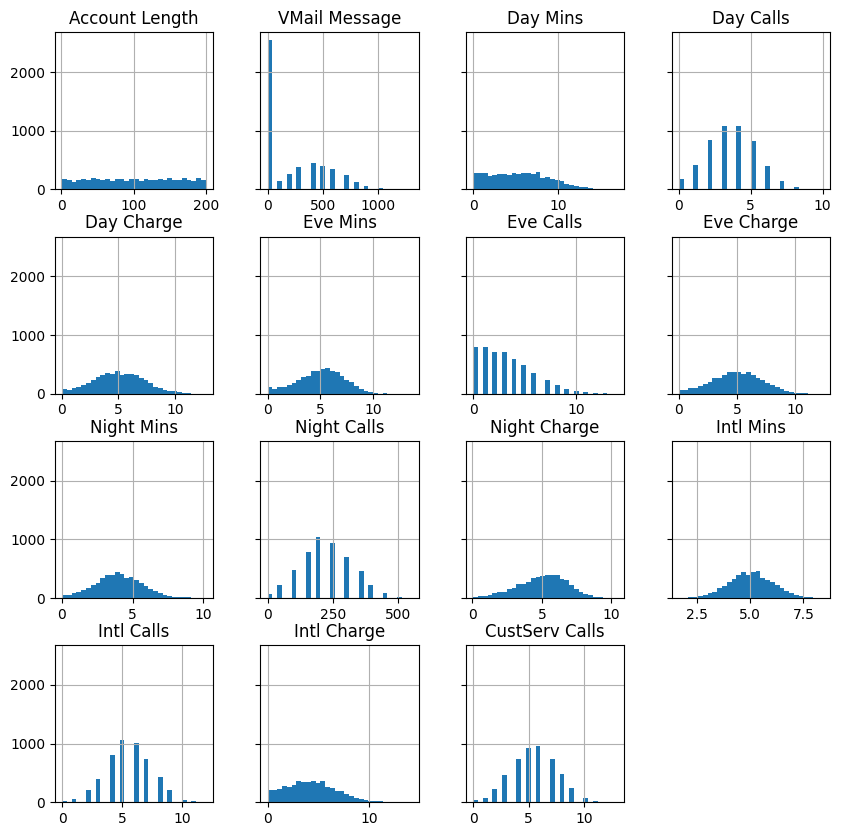

In [11]:
# some manual breakouts
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=["string"]).columns:
    display(
        pd.crosstab(index=df[column], columns="% observations", normalize="columns")
    )

# Histograms for each numeric features
display(df.describe())

hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

In [12]:
# data looks relatively evenly distributed
# note many VMail with zero messages

In [13]:
display(df.corr(numeric_only=True).style.background_gradient(cmap="Reds"))

In [14]:
# realculate the correlation matrix for numeric columns only
corr_matrix = df.corr(numeric_only=True)

# Define high correlation threshold
threshold = 0.55


# Function to apply color if correlation is high
def color_high_corr(val):
    color = "orange" if abs(val) > threshold else "none"
    return f"background-color: {color}"


# Apply the coloring function to the DataFrame
styled_corr_matrix = corr_matrix.style.map(color_high_corr)

# Display the styled DataFrame
display(styled_corr_matrix)

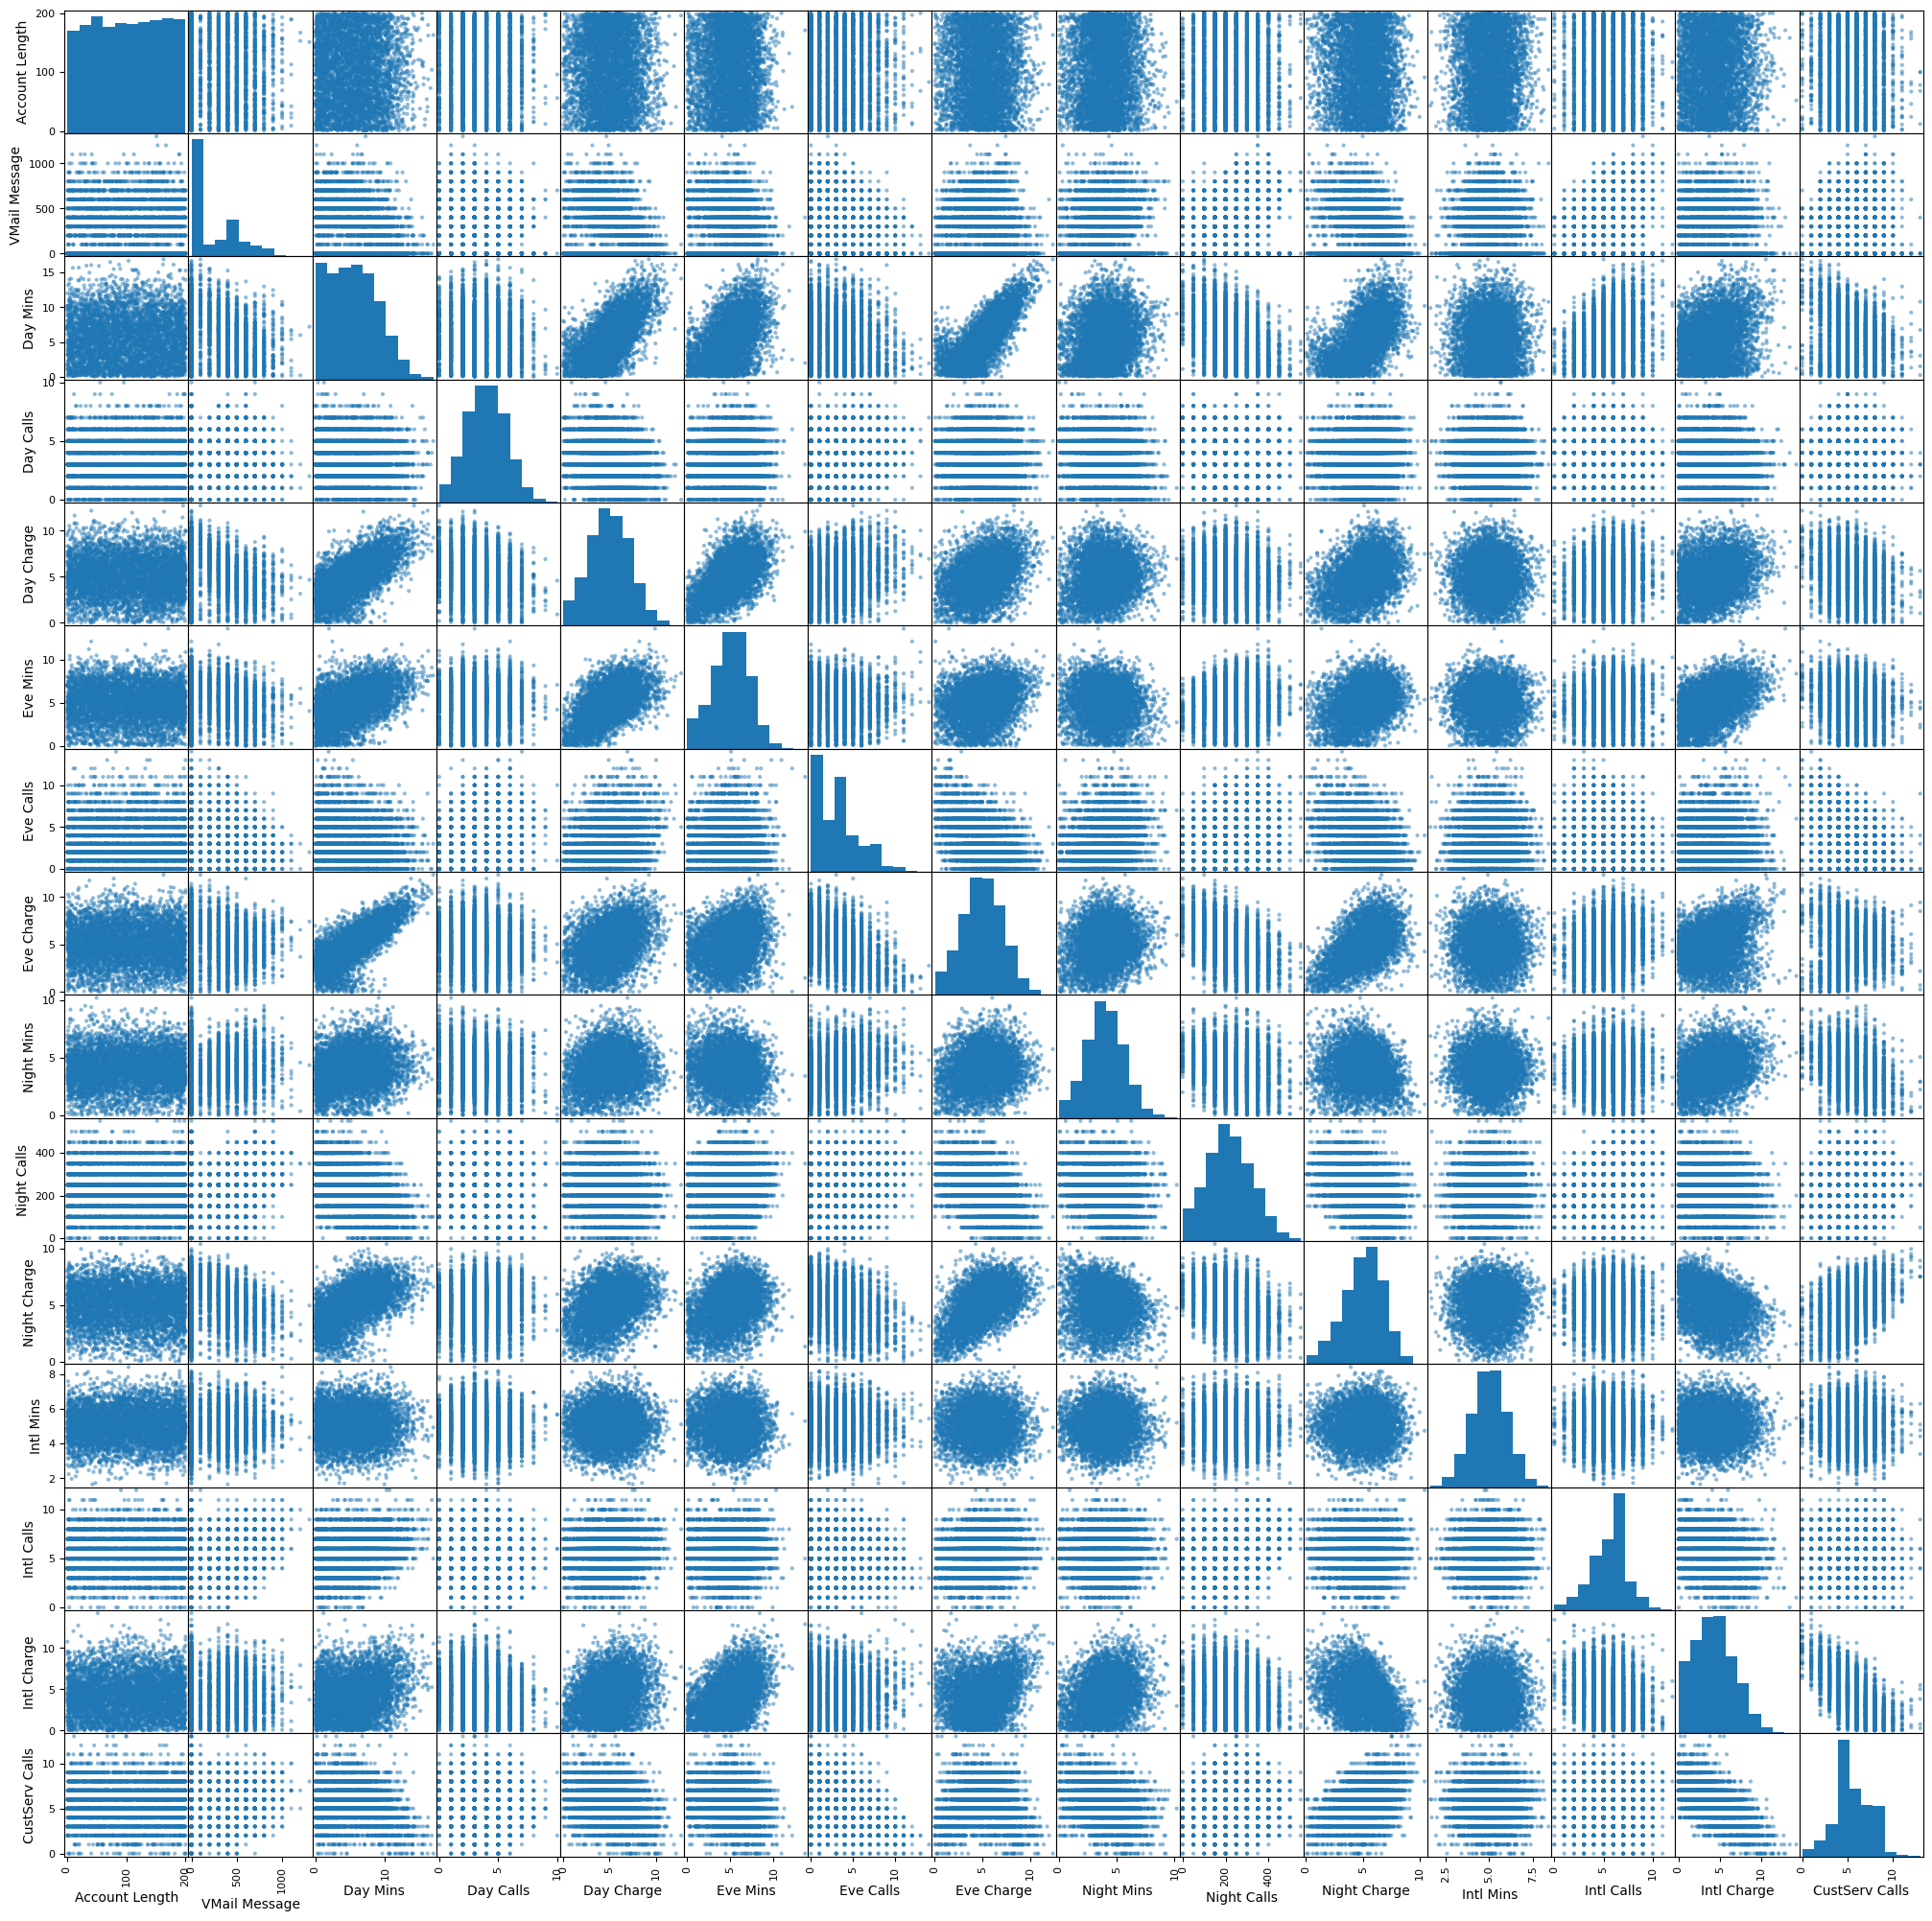

In [15]:
pd.plotting.scatter_matrix(df, figsize=(25, 25));

In [16]:
# looks like there are high correlation between the "Day Charge" "Eve Charge" and "Night Charge" columns vs. Day Mins -- so let's drop the Charge columns, since they will be some scalar value * some num of minutes

df = df.drop(labels=["Day Charge", "Eve Charge", "Night Charge"], axis=1)

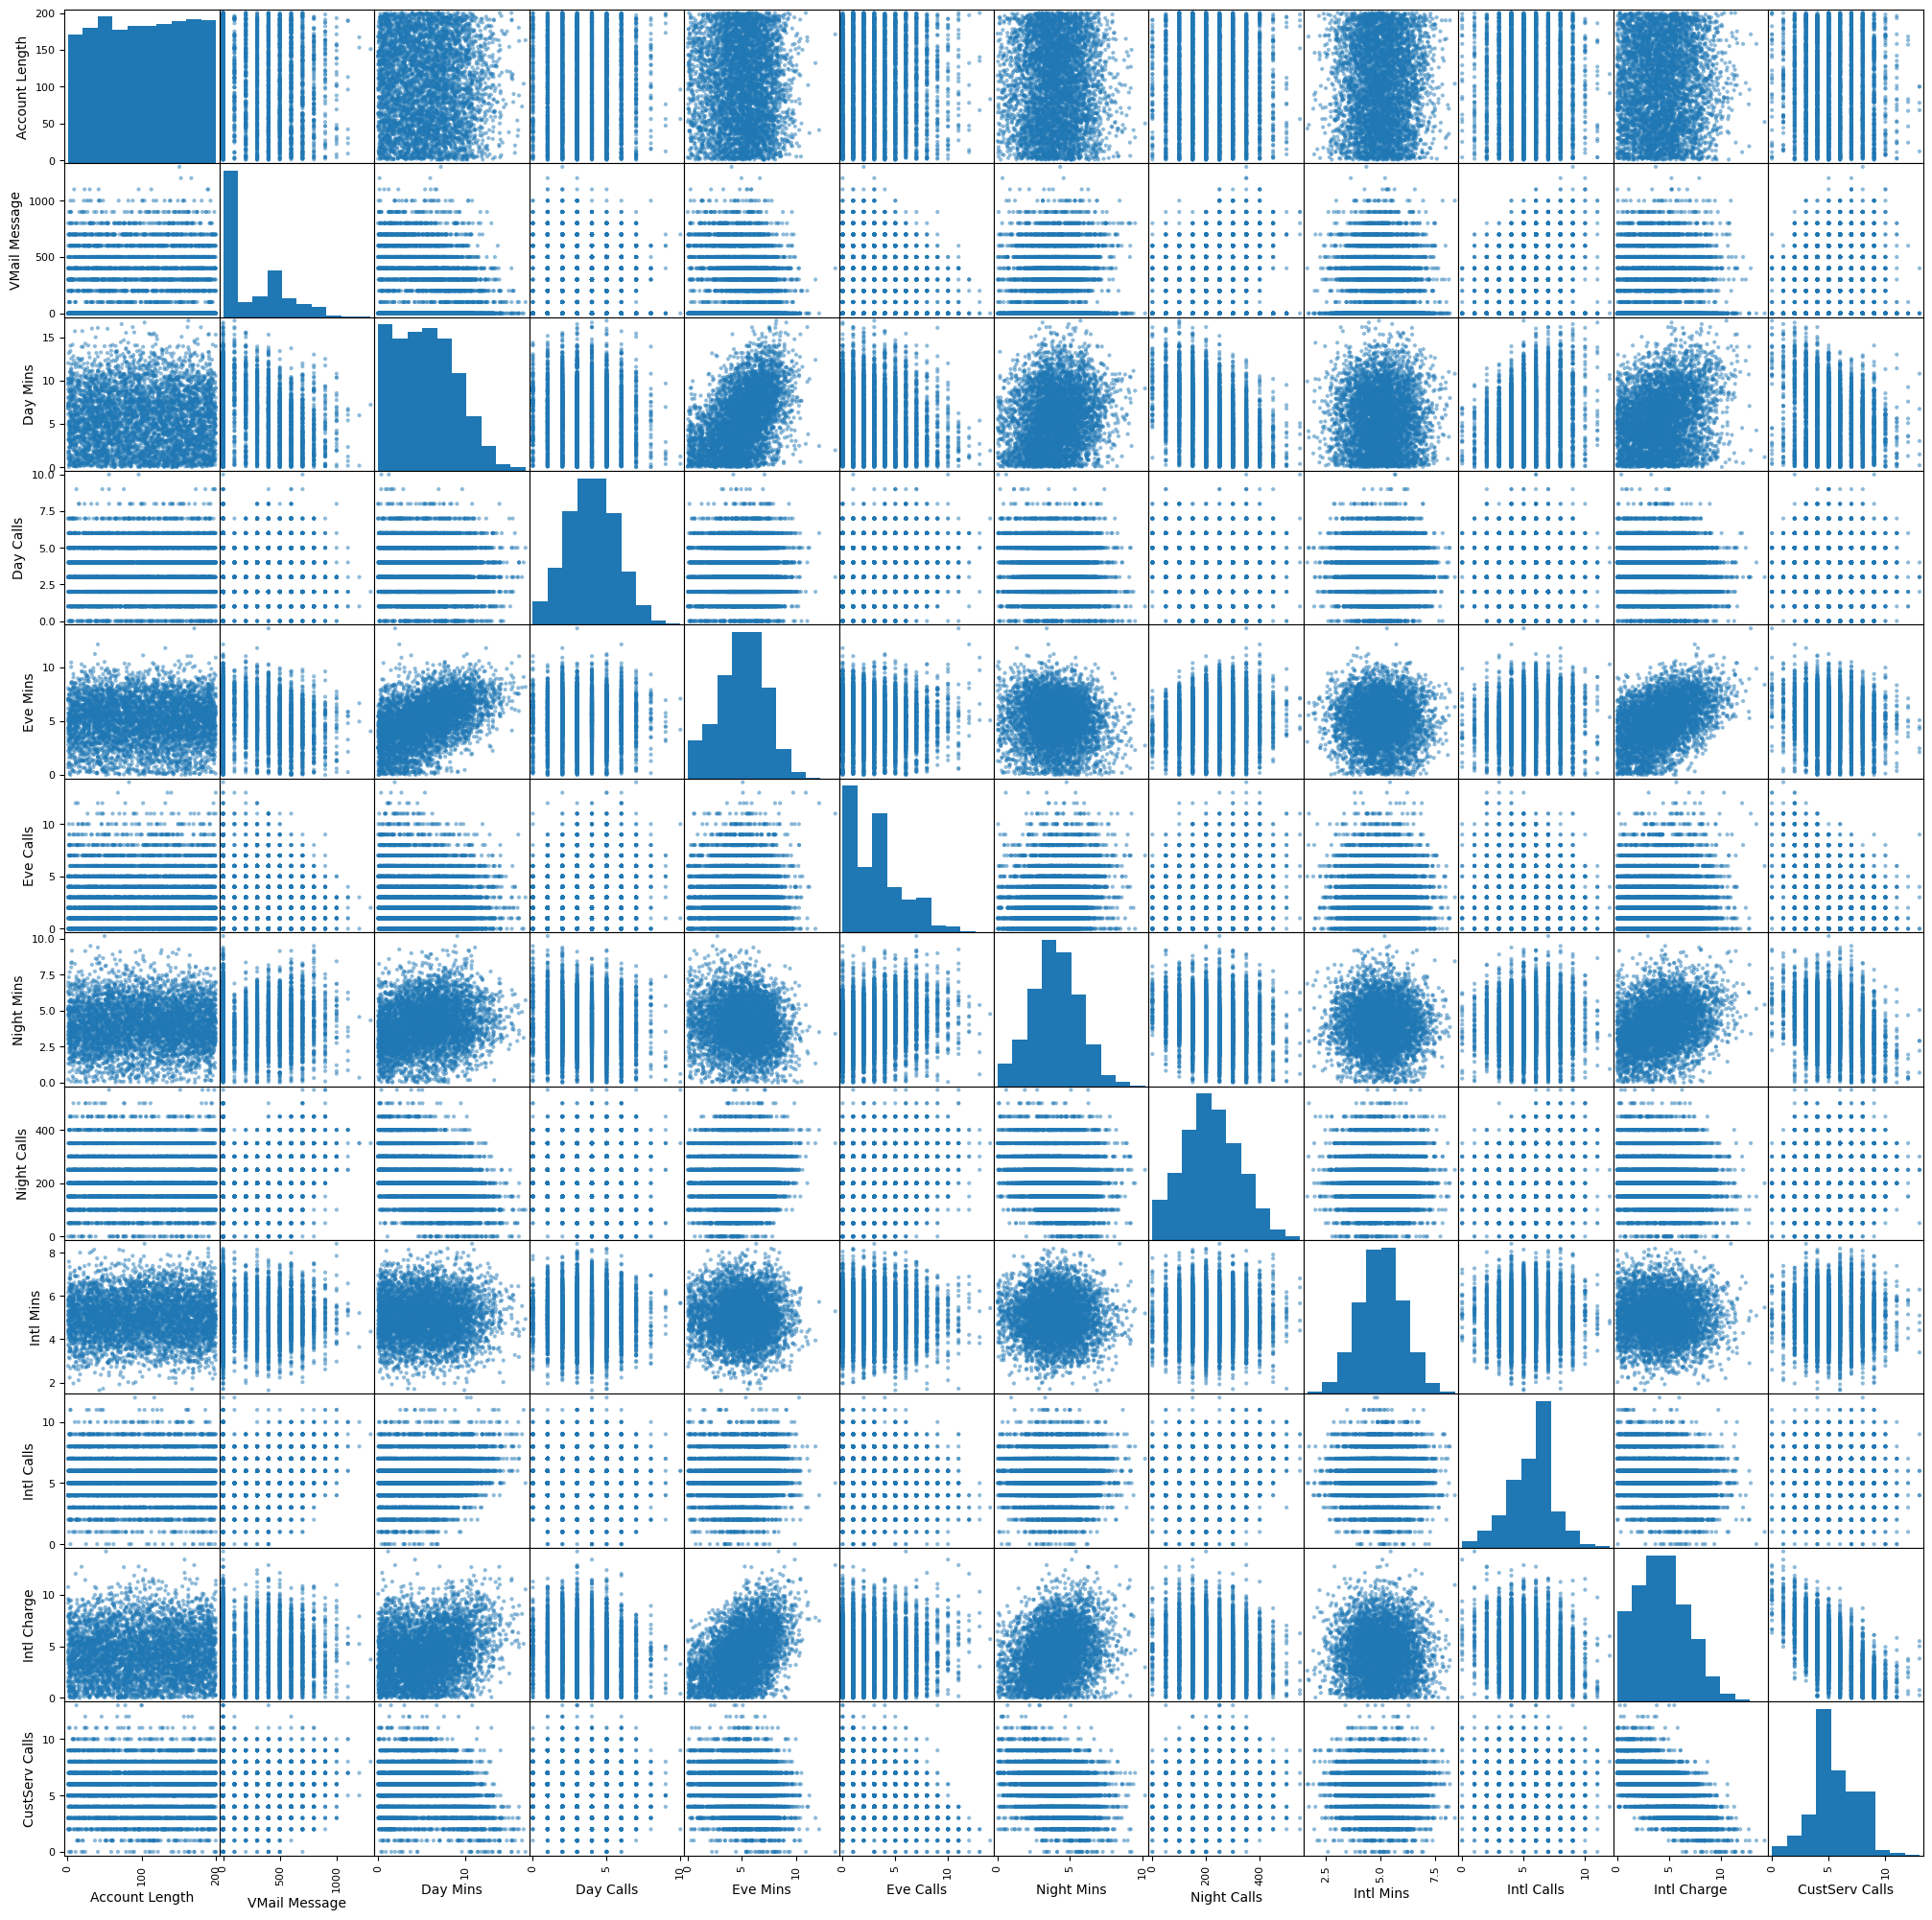

In [17]:
# let's graph this
pd.plotting.scatter_matrix(df, figsize=(25, 25));

# Start modeling

In [18]:
# get dummy values for category/string columns
model_data = pd.get_dummies(df)
model_data = pd.concat(
    [
        model_data["Churn?_True"],
        model_data.drop(["Churn?_False", "Churn?_True"], axis=1),
    ],
    axis=1,
)

In [19]:
!pip install umap-learn

In [20]:
train_data, validation_data, test_data = np.split(
    model_data.sample(frac=1, random_state=1729),
    [int(0.7 * len(model_data)), int(0.9 * len(model_data))],
)

train_data.to_csv("./data/train.csv", header=False, index=False)
validation_data.to_csv("./data/validation.csv", header=False, index=False)

/home/chris/dev/xgb_customer_churn/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
train_data

Churn?_True  Account Length  VMail Message   Day Mins  Day Calls  \
1697         True              14            300   4.216536          3   
340         False              97              0   3.122199          5   
1927        False              17            300   1.460867          5   
2330         True             144            200  10.026924          4   
2631        False             199              0   5.127774          2   
...           ...             ...            ...        ...        ...   
758          True             176              0  10.923908          7   
2806        False             191            700   1.647201          3   
1195        False             171              0   6.170572          2   
3969        False              91              0   2.565038          5   
1358        False              40              0   5.801733          2   

      Eve Mins  Eve Calls  Night Mins  Night Calls  Intl Mins  Intl Calls  \
1697  7.175133          1    0.077795          300   6.140715           5   
340   3.293510         10    4.663837          150   5.146710           5   
1927  3.511496          6    4.027071          250   6.525878           5   
2330  6.811761          1    3.506234          100   4.110792           6   
2631  1.697019          2    4.530190          150   7.291169           5   
...        ...        ...         ...          ...        ...         ...   
758   8.938584          4    4.014275          200   5.268068           7   
2806  3.454978          1    3.055748          300   3.656725           5   
1195  4.817509          0    3.502425          300   5.294645           6   
3969  5.880428          8    2.516378          400   4.561388           8   
1358  6.400124          2    2.259268          150   4.340251           5   

      Intl Charge  CustServ Calls  State_AK  State_AL  State_AR  State_AZ  \
1697     0.593857              10     False     False     False     False   
340      4.443320               2     False     False     False     False   
1927     3.010828               5     False     False      True     False   
2330     3.713233               6     False     False     False     False   
2631     1.742844               7     False     False     False     False   
...           ...             ...       ...       ...       ...       ...   
758      5.872329               3     False     False     False     False   
2806     2.749727               8     False     False     False     False   
1195     2.980535               8     False     False     False     False   
3969     3.805718               3     False     False      True     False   
1358     4.227653               9     False     False     False     False   

      State_CA  State_CO  State_CT  State_DC  State_DE  State_FL  State_GA  \
1697     False     False     False     False     False     False     False   
340       True     False     False     False     False     False     False   
1927     False     False     False     False     False     False     False   
2330     False     False     False     False     False     False     False   
2631     False     False      True     False     False     False     False   
...        ...       ...       ...       ...       ...       ...       ...   
758      False     False     False     False     False     False     False   
2806     False     False     False     False     False     False     False   
1195     False     False     False     False     False     False     False   
3969     False     False     False     False     False     False     False   
1358     False     False     False     False     False     False     False   

      State_HI  State_IA  State_ID  State_IL  State_IN  State_KS  State_KY  \
1697     False     False     False     False     False     False     False   
340      False     False     False     False     False     False     False   
1927     False     False     False     False     False     False     False   
2330     False    

In [22]:
from sklearn.preprocessing import StandardScaler

In [29]:
# Umap visualization
# Create the mapper
mapper = umap.UMAP()

embedding = mapper.fit_transform(train_data)

/home/chris/dev/xgb_customer_churn/venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


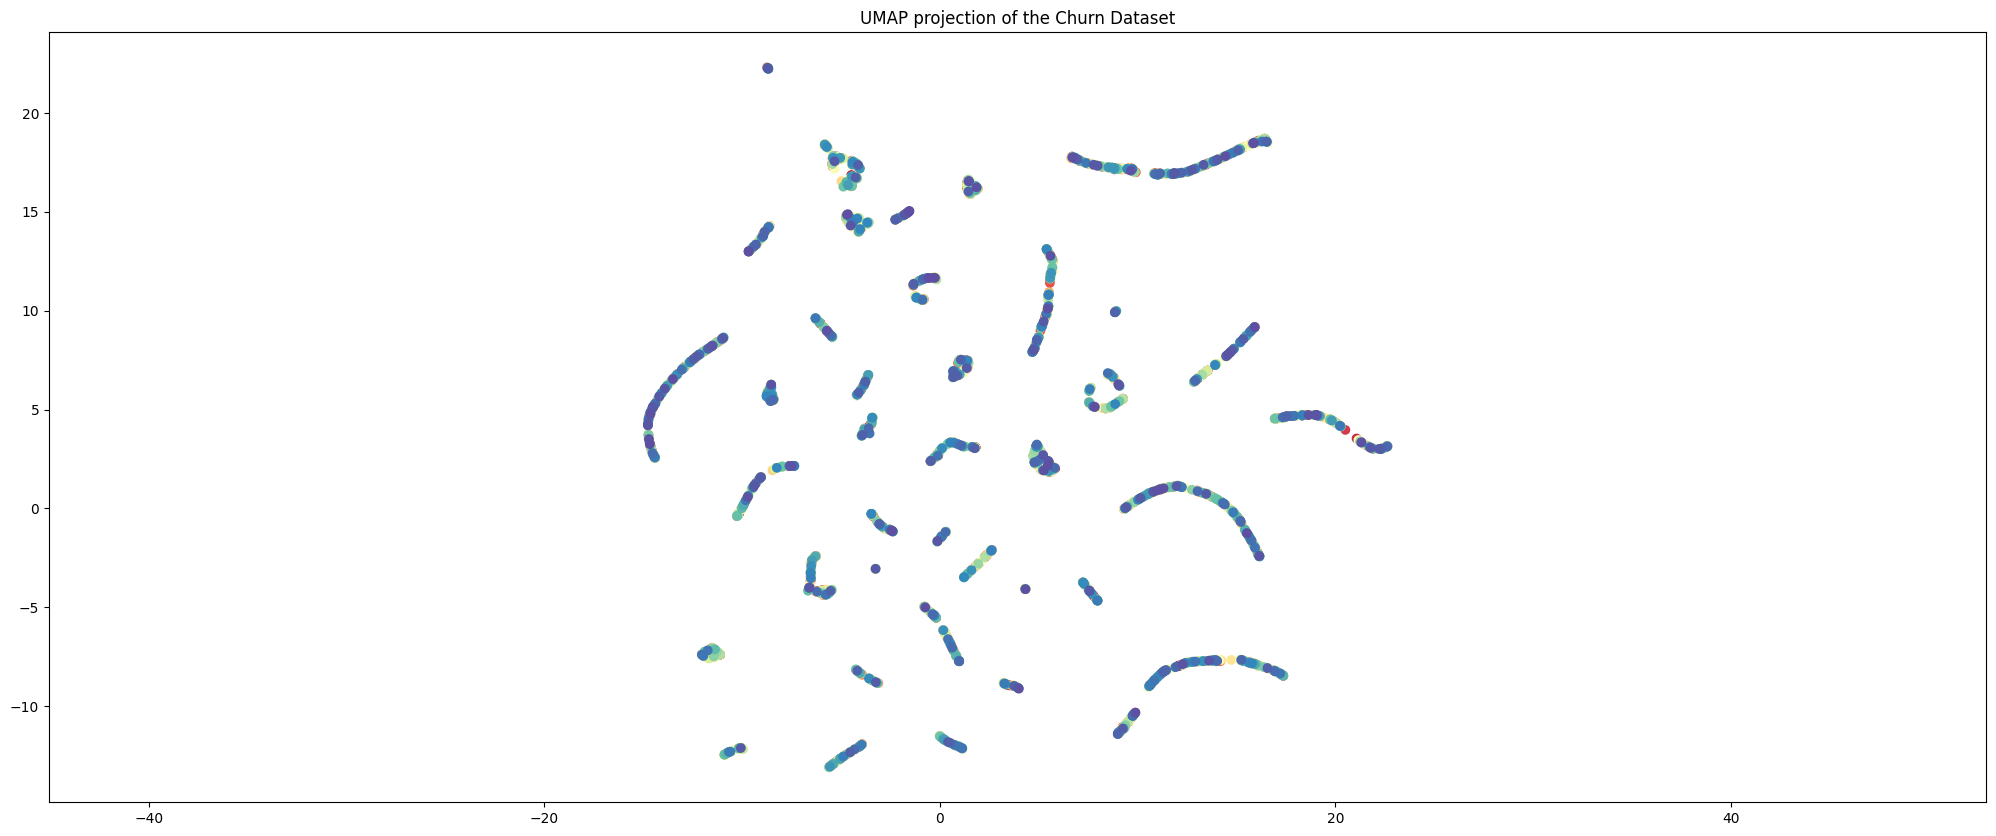

In [30]:
# scatter plot with a colormap
plt.figure(figsize=(25, 10))
plt.gca().set_aspect("equal", "datalim")
plt.title("UMAP projection of the Churn Dataset", fontsize=12)

# The third argument can be any array of the same length as the embedding data
plt.scatter(embedding[:, 0], embedding[:, 1], c=range(len(embedding)), cmap="Spectral")
plt.show()

In [31]:
# interesting, the data has clear clusters -- some are long ranges / curves -- long mostly purple/green lines
# and there are also some very tight clusers
# also single outliers - dark purple dots alone

# Lazypredict - let's see what the quick and dirty results look like

In [52]:
# using lazypredict lib
# link to our project data -- be sure to use `model_data` that has been converted to numeric, not the original df
X = model_data.drop(["Churn?_True"], axis=1)
Y = model_data[
    "Churn?_True"
]  # this column contains our targets - did the user churn or not

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

clf_lazy = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
clf_models, clf_predictions = clf_lazy.fit(X_train, X_test, y_train, y_test)

clf_models

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:04<00:00,  6.80it/s]

[LightGBM] [Info] Number of positive: 2017, number of negative: 1983
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1560
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.504250 -> initscore=0.017000
[LightGBM] [Info] Start training from score 0.017000


Accuracy  Balanced Accuracy  ROC AUC  F1 Score  \
Model                                                                           
QuadraticDiscriminantAnalysis      0.95               0.95     0.95      0.95   
SVC                                0.93               0.93     0.93      0.93   
XGBClassifier                      0.93               0.93     0.93      0.93   
ExtraTreesClassifier               0.93               0.93     0.93      0.93   
LGBMClassifier                     0.93               0.93     0.93      0.93   
RandomForestClassifier             0.92               0.92     0.92      0.92   
NuSVC                              0.91               0.91     0.91      0.91   
KNeighborsClassifier               0.91               0.91     0.91      0.91   
LabelPropagation                   0.90               0.90     0.90      0.90   
LabelSpreading                     0.90               0.90     0.90      0.90   
BaggingClassifier                  0.90               0.90     0.90      0.90   
DecisionTreeClassifier             0.87               0.87     0.87      0.87   
LinearSVC                          0.86               0.86     0.86      0.86   
CalibratedClassifierCV             0.86               0.86     0.86      0.86   
LogisticRegression                 0.85               0.86     0.86      0.85   
AdaBoostClassifier                 0.85               0.86     0.86      0.85   
LinearDiscriminantAnalysis         0.85               0.85     0.85      0.85   
RidgeClassifier                    0.85               0.85     0.85      0.85   
RidgeClassifierCV                  0.85               0.85     0.85      0.85   
SGDClassifier                      0.85               0.85     0.85      0.85   
GaussianNB                         0.85               0.85     0.85      0.85   
NearestCentroid                    0.83               0.83     0.83      0.83   
ExtraTreeClassifier                0.82               0.82     0.82      0.82   
BernoulliNB                        0.80               0.80     0.80      0.80   
PassiveAggressiveClassifier        0.77               0.77     0.77      0.77   
Perceptron                         0.76               0.76     0.76      0.76   
DummyClassifier                    0.48               0.50     0.50      0.31   

                               Time Taken  
Model                                      
QuadraticDiscriminantAnalysis        0.03  
SVC                                  0.21  
XGBClassifier                        0.11  
ExtraTreesClassifier                 0.26  
LGBMClassifier                       0.09  
RandomForestClassifier               0.61  
NuSVC                                0.45  
KNeighborsClassifier                 0.11  
LabelPropagation                     0.51  
LabelSpreading                       0.66  
BaggingClassifier                    0.20  
DecisionTreeClassifier               0.06  
LinearSVC                            0.17  
CalibratedClassifierCV               0.12  
LogisticRegression                   0.04  
AdaBoostClassifier                   0.32  
LinearDiscriminantAnalysis           0.05  
RidgeClassifier                      0.02  
RidgeClassifierCV                    0.05  
SGDClassifier                        0.07  
GaussianNB                           0.01  
NearestCentroid                      0.02  
ExtraTreeClassifier                  0.01  
BernoulliNB                          0.01  
PassiveAggressiveClassifier          0.02  
Perceptron                           0.03  
DummyClassifier                      0.01

In [53]:
# looks like we should be able to hit ~0.93 with XGBoost

In [54]:
xgb_clf = XGBClassifier(random_state=42, seed=2, colsample_bytree=0.6, subsample=0.7)
xgb_clf.fit(X_train, y_train.astype(int))

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [55]:
xgb_clf.score(X_test, y_test.astype(int))

0.912

In [ ]:
# OKAY - 91.2% on first pass, let's try some hyperparameter optimization to get above 93

In [59]:
# Define the parameter grid
param_grid = {
    "max_depth": [3, 4, 5],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 300],
    "subsample": [0.7, 0.8, 0.9],
    "colsample_bytree": [0.6, 0.7, 0.8],
}

# Create the classifier
xgb_clf = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1
)  # cv=num of cross val folds; n_jobs=-1 uses all cpu cores

# Fit the grid search to the data
grid_search.fit(
    X_train, y_train.astype(int)
)  # .astype(int) correctly infers bool target col dtype

# Print best parameters we found
print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}


In [60]:
# grid search cross validation instantiation
xgb_clf = XGBClassifier(
    random_state=42,
    seed=2,
    colsample_bytree=0.8,
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
)
xgb_clf.fit(X_train, y_train.astype(int))
xgb_clf.score(X_test, y_test.astype(int))

0.928

In [61]:
# hmmm - better, but what else can we do?
# explore some optimization libraries

In [85]:
# using hyperopt library
# define search space -- key parameters and ranges
space = {
    "max_depth": hp.quniform("max_depth", 3, 18, 1),
    "gamma": hp.uniform("gamma", 1, 9),
    "reg_alpha": hp.quniform("reg_alpha", 40, 180, 1),
    "reg_lambda": hp.uniform("reg_lambda", 0, 1),
    "colsample_bytree": hp.uniform("colsample_bytree", 0.5, 1),
    "subsample": hp.uniform("subsample", 0.5, 1),
    "min_child_weight": hp.quniform("min_child_weight", 0, 10, 1),
    "n_estimators": 300,
    "seed": 42,
}

In [91]:
# define function to feed parameters from search space into classifier, and log output


def objective(space):
    clf_search = XGBClassifier(
        n_estimators=space["n_estimators"],
        max_depth=int(space["max_depth"]),
        gamma=space["gamma"],
        reg_alpha=int(space["reg_alpha"]),
        min_child_weight=int(space["min_child_weight"]),
        colsample_bytree=int(space["colsample_bytree"]),
        subsample_bytree=int(space["subsample"]),
    )

    evaluation = [(X_train, y_train.astype(int)), (X_test, y_test.astype(int))]

    clf_search.fit(
        X_train,
        y_train,
        eval_set=evaluation,
        eval_metric="auc",
        early_stopping_rounds=10,
        verbose=False,
    )

    pred = clf_search.predict(X_test)
    accuracy = accuracy_score(y_test, pred > 0.5)
    # print(f"Score: {accuracy}")
    return {"loss": -accuracy, "status": STATUS_OK}

In [92]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective, space=space, algo=tpe.suggest, max_evals=250, trials=trials
)
best_hyperparams

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:34<00:00,  7.16trial/s, best loss: -0.564]


{'colsample_bytree': 0.8124085750652259,
 'gamma': 4.1823773112312805,
 'max_depth': 18.0,
 'min_child_weight': 1.0,
 'reg_alpha': 84.0,
 'reg_lambda': 0.6522001852360964,
 'subsample': 0.5737941761709606}

In [98]:
xgb_clf = XGBClassifier(
    random_state=42,
    seed=2,
    learning_rate=0.3,
    max_depth=int(best_hyperparams["max_depth"]),
    gamma=best_hyperparams["gamma"],
    reg_alpha=int(best_hyperparams["reg_alpha"]),
    min_child_weight=int(best_hyperparams["min_child_weight"]),
    colsample_bytree=int(best_hyperparams["colsample_bytree"]),
    subsample_bytree=int(best_hyperparams["subsample"]),
)

xgb_clf.fit(X_train, y_train.astype(int))
xgb_clf.score(X_test, y_test.astype(int))

0.79

In [ ]:
# this search space is not the same; much deeper - 18; let's try a broader gridsearch

In [ ]:
# Define the parameter grid
param_grid = {
    "max_depth": [3, 4, 5, 6, 7 , 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
    "learning_rate": [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3],
    "n_estimators": [100, 150, 200, 250, 300, 350, 400],
    "subsample": [0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    "colsample_bytree": [0.6, 0.65, 0.7, 0.75, 0.8, 0.85],
}

# Create the classifier
xgb_clf = XGBClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=xgb_clf, param_grid=param_grid, scoring="accuracy", cv=5, n_jobs=-1
)  # cv=num of cross val folds; n_jobs=-1 uses all cpu cores

# Fit the grid search to the data
grid_search.fit(
    X_train, y_train.astype(int)
)  # .astype(int) correctly infers bool target col dtype

# Print best parameters found
print("Best parameters found: ", grid_search.best_params_)

In [ ]:
# grid search cross validation instantiation
xgb_clf = XGBClassifier(
    random_state=42,
    seed=2,
    colsample_bytree=0.8,
    subsample=0.8,
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
)
xgb_clf.fit(X_train, y_train.astype(int))
xgb_clf.score(X_test, y_test.astype(int))

# look at SHAP explanation of the model features

In [ ]:
# Create a SHAP explainer using the XGBoost model from above
explainer = shap.Explainer(xgb_clf)

# Compute SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Generate a summary plot
shap.summary_plot(shap_values, X_train, plot_type="bar")